# **Exploring Errors in Regression**

This project studies regression of data whose underlying function varies from linear to very nonlinear using methods with different flexibility. From the class, we learned that the mean-squared errors $MSE$ is given as:



$
\begin{align}
E(y_0-\hat{f}(x_0))^2 = Var(\hat{f}(x_0)) + Bias[(\hat{f}(x_0))]^2 + Var(\epsilon)
\end{align}
$


where $Var(\hat{f})$ is the *Variance*, which refers to the amount by which $\hat{f}$ would change if we estimated it using a different training set; $Bias(\hat{f}) = E(\hat{f}) - f$ is the $Bias$, which refers to the error that is introduced by approximating a complicated real-life problem by a much simper model; and $Var(\epsilon)$ is the irreducible error. We will study the bias-variance tradeoff for different methods on different data.


**Data Generation:** I will be generating data using the following models. Let $y = f(x) + \epsilon$, where $\epsilon$ is the random noise (e.g. Gaussian) and $f(x)$ has three forms as:
1. A linear function $f(x) = ax + b$;
2. A quadratic function $f(x) = ax^2 + bx + c$;
3. A nonlinear function: e.g. $f(x) = x\sin(x)$, $f(x) = \frac{1}{1 + 25x^2}$ 
</br></br>
<ins>NOTE</ins>: I will be picking a domain and deciding how many data points to produce. I will be splitting my data into the training set and the test set randomly and so validation can be performed. For the random noise, I will be controlling the mean and variance, choosing them arbritrarily as I see fit.


**Regression Models:** I will use three regression methods to fit the data.
1. $Y = \beta_0 + \beta_1X$  $(df=2)$;
2. A smoothing cubic spline with degree of freedom 5;
3. A smoothing cubic spline with effective degree of freedom approximately 25. (<ins>NOTE</ins>: for smoothing spline I will adjust the smoothing parameters to control the level of flexibility or degree of freedom.)

**Research Objective:** I will use my data and methods to investigate the following topics.
1. The performance of methods with different flexibility on data from linear to nonlinear underlying functions.
2. How does the $MSE$, $Bias$, and $Var$ vary with method of different flexibility?
3. How does the variance of noise affect the performance of different method (e.g. similar to (1) but with a different noise level characterized by the variance). I will use the nonlinear data with different noise levels fitted by three methods, plot the model and calculate training $MSE$ and test $MSE$.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as stats
from csaps import csaps 
from sklearn.model_selection import train_test_split

## **Data Generation**

To generate data, I will first be establishing the true population models that I will be using to arbitrarily make predictions using various regression techniques. Here are my three functions that I'm choosing for this project, all of which have extreme varying complexity:

**Linear Model:** $f(x) = 10.73x + 3400$   


**Quadratic Model:** $f(x) = 10.73x^2 -5.00x + 3400$   


**Non-linear Model:** $f(x) = \frac{440x^2\arctan(\frac{1}{x + 1})\cos(\frac{x}{100})}{(x+1)^{1.8}}$   


The reason why I am using multiple models of varying complexities is because I want to observe exactly how our Regression methods react to different patterns of data. Depending on the flexibility and bias, Spline regression with a high degree of freedom for example might have a much more severe reaction to a more complex non-linear $f$ than a simple linear regression model would.



We fix our noise with $\epsilon := $ np.random.normal(0, $var$, $n$)

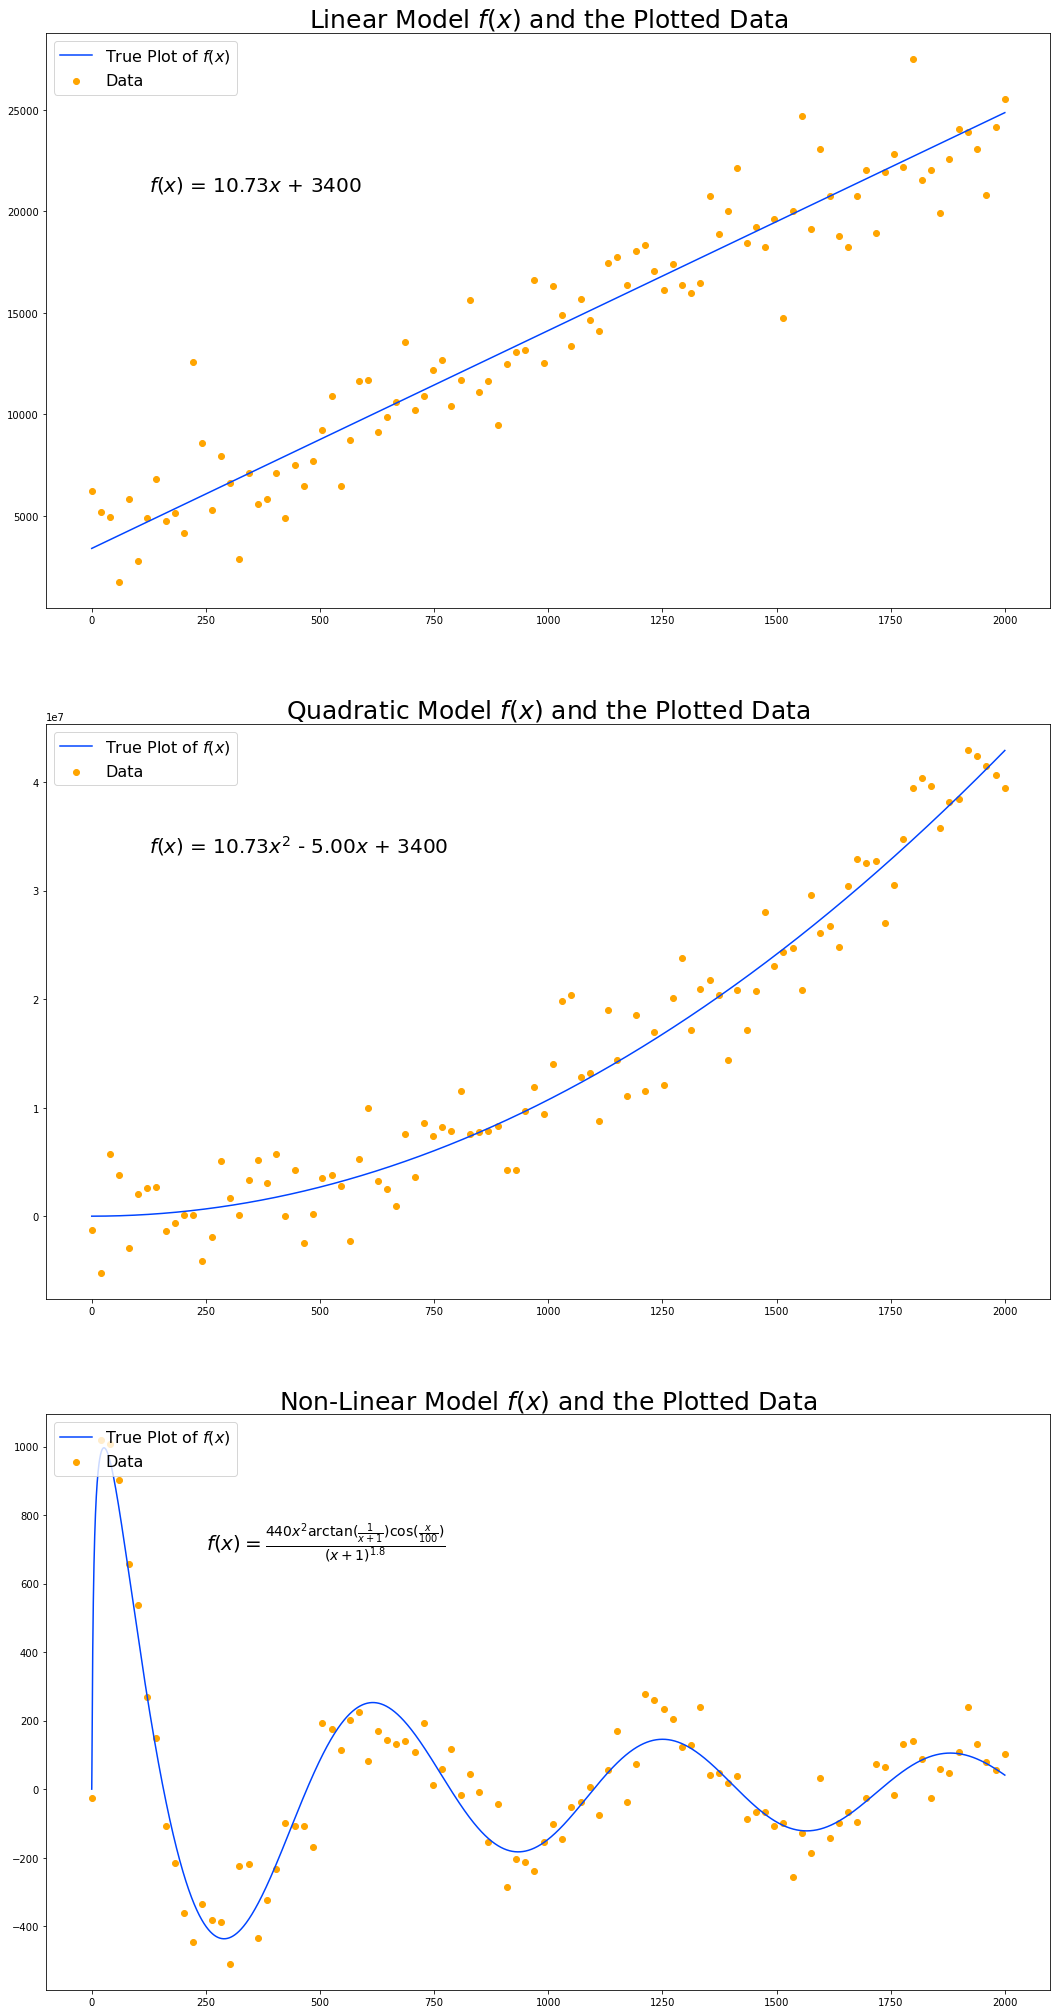

In [78]:
# Data count
n = 100

# x_values denotes the values of our independent variables
x_values = np.linspace(0,2000,n)
x_plot = np.linspace(x_values[0], x_values[-1], 100000)

# Underlying functions of data for linear, quadratic, and nonlinear cases
f_linear    = lambda x : 10.73*(x) + 3400
f_quadratic = lambda x : 10.73*(x**2) - 5*(x) + 3400
f_nonlinear = lambda x : (440 * (x**2) * np.arctan(100/((x + 1))) * np.cos(x/100) / (x + 1)**1.8)

# Generate random data using Gaussian Noise
## Linear Model
var1 = 1735
y_linear = f_linear(x_values) + np.random.normal(0, var1, n)

## Quadratic Model
var2 = 3110020
y_quadratic = f_quadratic(x_values) + np.random.normal(0, var2, n)

## Non-Linear Model
var3 = 86
y_nonlinear = f_nonlinear(x_values) + np.random.normal(0, var3, n)

# Plot the true graphs 
fig, ax = plt.subplots(3, figsize=(18,36))

ax[0].plot(x_plot, f_linear(x_plot), markersize=200, color="#0044FF", label=r"True Plot of $f(x)$")
ax[0].scatter(x_values, y_linear, color="#FFA500", label="Data")
ax[0].set_title(r"Linear Model $f(x)$ and the Plotted Data", size=25)
ax[0].text(125, 21000, r"$f(x)$ = $10.73x$ + $3400$", fontsize=20)
ax[0].legend(fontsize=16, loc="upper left")

ax[1].plot(x_plot, f_quadratic(x_plot), markersize=200, color="#0044FF", label=r"True Plot of $f(x)$")
ax[1].scatter(x_values, y_quadratic, color="#FFA500", label="Data")
ax[1].set_title(r"Quadratic Model $f(x)$ and the Plotted Data", size=25)
ax[1].text(125, 2**25, r"$f(x)$ = $10.73x^2$ - $5.00x$ + $3400$", fontsize=20)
ax[1].legend(fontsize=16, loc="upper left")

ax[2].plot(x_plot, f_nonlinear(x_plot), markersize=200, color="#0044FF", label=r"True Plot of $f(x)$")
ax[2].scatter(x_values, y_nonlinear, color="#FFA500", label="Data")
ax[2].set_title(r"Non-Linear Model $f(x)$ and the Plotted Data", size=25)
ax[2].text(250, 700, r"$f(x) = \frac{440x^2\arctan(\frac{1}{x + 1})\cos(\frac{x}{100})}{(x+1)^{1.8}}$", fontsize=20)
ax[2].legend(fontsize=16, loc="upper left")

plt.savefig("plots/Plotted_Data_and_True_Models.png")
plt.show()

## **Regression Models**

Now that we have our data, let's evaluate how various regression methods perform when fitting to the data. As a reminder, I will be using the following methods to evaluate which method fits the data best and which method fits the model best:
1. $Y = \beta_0 + \beta_1X$  $(df=2)$;
2. A smoothing cubic spline with degree of freedom 5;
3. A smoothing cubic spline with effective degree of freedom approximately 25. (<ins>NOTE</ins>: for smoothing spline I will adjust the smoothing parameters to control the level of flexibility or degree of freedom.)

### **Splitting Our Data into Training and Testing Sets**

We have our data, but we need to split it now into a training dataset and a testing dataset. The reasoning why I am following this approach is because this enables me to both create a model $\hat{f}(x)$ appropriate for the shape of our data and test it on data that my program did not see during the training process. To split our data accordingly, I will use the cross-validation. In the cross-validation approach, the model is fit on the training set then applied to predict the response variable $y$ in the testing set. Scikit-Learn's train_test_split() performs this operation, and I will ensure that the function randomly splits 75% of our data into the training set and 25% of it on the testing data. 

In [166]:
# Split randomized data into independent and dependent training and testing data
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(x_values, y_linear, test_size=0.25, random_state=42, shuffle=True)
X_train_quad, X_test_quad, y_train_quad, y_test_quad = train_test_split(x_values, y_quadratic, test_size=0.25, random_state=42, shuffle=True)
X_train_nonlin, X_test_nonlin, y_train_nonlin, y_test_nonlin = train_test_split(x_values, y_nonlinear, test_size=0.25, random_state=42, shuffle=True)

# Sort the data [REQUIRED FOR csaps() FUNCTION]
X_train_lin, y_train_lin = (list(t) for t in zip(*sorted(zip(X_train_lin, y_train_lin))))
X_test_lin, y_test_lin = (list(t) for t in zip(*sorted(zip(X_test_lin, y_test_lin))))

X_train_quad, y_train_quad = (list(t) for t in zip(*sorted(zip(X_train_quad, y_train_quad))))
X_test_quad, y_test_quad = (list(t) for t in zip(*sorted(zip(X_test_quad, y_test_quad))))

X_train_nonlin, y_train_nonlin = (list(t) for t in zip(*sorted(zip(X_train_nonlin, y_train_nonlin))))
X_test_nonlin, y_test_nonlin = (list(t) for t in zip(*sorted(zip(X_test_nonlin, y_test_nonlin))))

# Convert to numpy array
X_train_lin = np.array(X_train_lin) 
y_train_lin = np.array(y_train_lin) 
X_test_lin  = np.array(X_test_lin) 
y_test_lin  = np.array(y_test_lin) 

X_train_quad = np.array(X_train_quad) 
y_train_quad = np.array(y_train_quad) 
X_test_quad  = np.array(X_test_quad) 
y_test_quad  = np.array(y_test_quad) 

X_train_nonlin = np.array(X_train_nonlin) 
y_train_nonlin = np.array(y_train_nonlin) 
X_test_nonlin  = np.array(X_test_nonlin) 
y_test_nonlin  = np.array(y_test_nonlin) 

TO DO: Talk about degrees of freedon, what it means in the concept of cubic splines, and go over the calculation

In [167]:
#Function returning the effective degree of freedom for a training data (predictor X only) and a smooth parameter p
def effect_df(X,p):
    n = len(X)
    Y = np.eye((n))
    R = np.zeros((n,n))
    for i in range(n):
        yb=Y[:,i];
        R[:,i]=csaps(X,yb,X,smooth=p)
    return R.trace()

In [168]:
# Choose smooth values to optimally arrive at df=2 and df=5
print("Linear Model:")
smoothness1 = 0
print(f"\tFor DF={effect_df(X_train_lin, smoothness1):.10f}, smooth={smoothness1}")
smoothness2 = 0.0000000270865
print(f"\tFor DF={effect_df(X_train_lin, smoothness2):.10f}, smooth={smoothness2}")
smoothness3 = 0.000039092
print(f"\tFor DF={effect_df(X_train_lin, smoothness3):.10f}, smooth={smoothness3}")

print("Quadratic Model:")
smoothness4 = 0
print(f"\tFor DF={effect_df(X_train_quad, smoothness4):.10f}, smooth={smoothness4}")
smoothness5 = 0.0000000270865
print(f"\tFor DF={effect_df(X_train_quad, smoothness5):.10f}, smooth={smoothness5}")
smoothness6 = 0.000039092
print(f"\tFor DF={effect_df(X_train_quad, smoothness6):.10f}, smooth={smoothness6}")

print("Non-Linear Model:")
smoothness7 = 0
print(f"\tFor DF={effect_df(X_train_nonlin, smoothness7):.10f}, smooth={smoothness7}")
smoothness8 = 0.0000000270865
print(f"\tFor DF={effect_df(X_train_nonlin, smoothness8):.10f}, smooth={smoothness8}")
smoothness9 = 0.000039092
print(f"\tFor DF={effect_df(X_train_nonlin, smoothness9):.10f}, smooth={smoothness9}")

Linear Model:
	For DF=2.0000000000, smooth=0
	For DF=5.0000288312, smooth=2.70865e-08
	For DF=25.0000965123, smooth=3.9092e-05
Quadratic Model:
	For DF=2.0000000000, smooth=0
	For DF=5.0000288312, smooth=2.70865e-08
	For DF=25.0000965123, smooth=3.9092e-05
Non-Linear Model:
	For DF=2.0000000000, smooth=0
	For DF=5.0000288312, smooth=2.70865e-08
	For DF=25.0000965123, smooth=3.9092e-05


In [169]:
# Calculate Splines (methods with different degree of freedom controled by "smooth" parameter)
y_sp1_lin = csaps(X_train_lin, y_train_lin, x_plot, smooth=smoothness1)
y_sp2_lin = csaps(X_train_lin, y_train_lin, x_plot, smooth=smoothness2)
y_sp3_lin = csaps(X_train_lin, y_train_lin, x_plot, smooth=smoothness3)

y_sp1_quad = csaps(X_train_quad, y_train_quad, x_plot, smooth=smoothness4)
y_sp2_quad = csaps(X_train_quad, y_train_quad, x_plot, smooth=smoothness5)
y_sp3_quad = csaps(X_train_quad, y_train_quad, x_plot, smooth=smoothness6)

y_sp1_nonlin = csaps(X_train_nonlin, y_train_nonlin, x_plot, smooth=smoothness7)
y_sp2_nonlin = csaps(X_train_nonlin, y_train_nonlin, x_plot, smooth=smoothness8)
y_sp3_nonlin = csaps(X_train_nonlin, y_train_nonlin, x_plot, smooth=smoothness9)

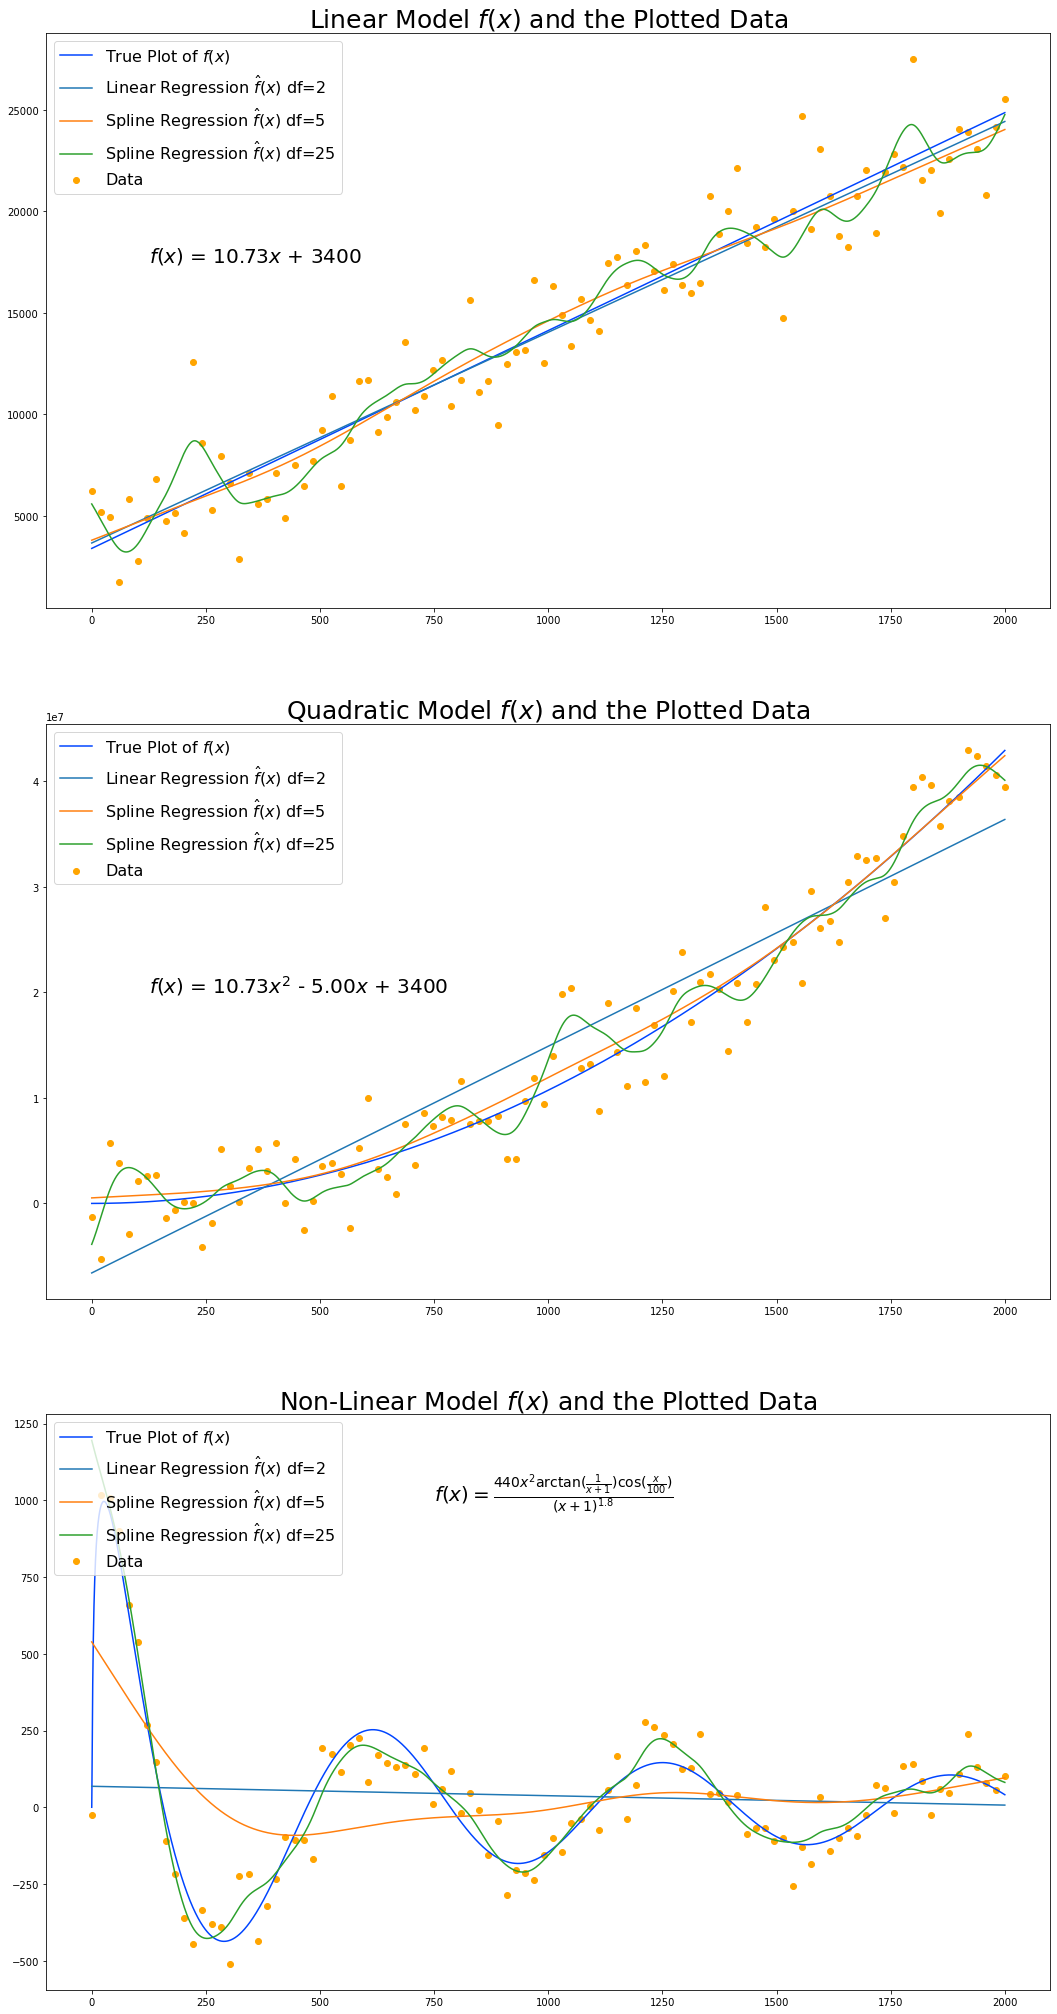

In [172]:
# Plot Results
fig, ax = plt.subplots(3, figsize=(18,36))

ax[0].plot(x_plot, f_linear(x_plot), markersize=1000, color="#0044FF", label=r"True Plot of $f(x)$")
ax[0].scatter(x_values, y_linear, color="#FFA500", label="Data")
ax[0].plot(x_plot, y_sp1_lin, label=r"Linear Regression $\hat{f}(x)$ df=2")
ax[0].plot(x_plot, y_sp2_lin, label=r"Spline Regression $\hat{f}(x)$ df=5")
ax[0].plot(x_plot, y_sp3_lin, label=r"Spline Regression $\hat{f}(x)$ df=25")
ax[0].set_title(r"Linear Model $f(x)$ and the Plotted Data", size=25)
ax[0].text(125, 17500, r"$f(x)$ = $10.73x$ + $3400$", fontsize=20)
ax[0].legend(fontsize=16, loc="upper left")

ax[1].plot(x_plot, f_quadratic(x_plot), markersize=1000, color="#0044FF", label=r"True Plot of $f(x)$")
ax[1].scatter(x_values, y_quadratic, color="#FFA500", label="Data")
ax[1].plot(x_plot, y_sp1_quad, label=r"Linear Regression $\hat{f}(x)$ df=2")
ax[1].plot(x_plot, y_sp2_quad, label=r"Spline Regression $\hat{f}(x)$ df=5")
ax[1].plot(x_plot, y_sp3_quad, label=r"Spline Regression $\hat{f}(x)$ df=25")
ax[1].set_title(r"Quadratic Model $f(x)$ and the Plotted Data", size=25)
ax[1].text(125, 2**24.25, r"$f(x)$ = $10.73x^2$ - $5.00x$ + $3400$", fontsize=20)
ax[1].legend(fontsize=16, loc="upper left")

ax[2].plot(x_plot, f_nonlinear(x_plot), markersize=1000, color="#0044FF", label=r"True Plot of $f(x)$")
ax[2].scatter(x_values, y_nonlinear, color="#FFA500", label="Data")
ax[2].plot(x_plot, y_sp1_nonlin, label=r"Linear Regression $\hat{f}(x)$ df=2")
ax[2].plot(x_plot, y_sp2_nonlin, label=r"Spline Regression $\hat{f}(x)$ df=5")
ax[2].plot(x_plot, y_sp3_nonlin, label=r"Spline Regression $\hat{f}(x)$ df=25")
ax[2].set_title(r"Non-Linear Model $f(x)$ and the Plotted Data", size=25)
ax[2].text(750, 1000, r"$f(x) = \frac{440x^2\arctan(\frac{1}{x + 1})\cos(\frac{x}{100})}{(x+1)^{1.8}}$", fontsize=20)
ax[2].legend(fontsize=16, loc="upper left")

plt.savefig("plots/Regression_Estimates.png")
plt.show()

In [ ]:
# Initialize values for random repeated sampling with replacement
num_iter = 2000 
random_seed = 123
rng = np.random.RandomState(123) # Initialize random number generator

p = 0.90

## **Research Objective**

First, we will need to perform Bootstrap Sampling. Bootstrap Sampling is the repetitive random selection of sample data to estimate a population parameter. To put that in Layman's terms, Bootstrap Sampling involves selecting a subset of our sample multiple times with replacement—meaning that the data selected in each subset can reappear in the next subset and so forth—to predict $f(x)$, which is the true model. Our predicted model will be denoted as $\hat{f}(x)$. We will perform Bootstrap Sampling using scikit-learn's train_test_split() function and my draw_bootstrap_sample() function repetitively to separate our entire dataset into a random training set and a random testing set every single time. Then, we will factor in our results to our final model predictions. By repetitively going through this process, we can estimate the variability of our estimate $\hat{f}(x)$ without generating additional samples.

In [80]:
# Function for bootstrap resampling: 
def draw_bootstrap_sample(rng, X, y):
    """
    Function for bootstrap resampling. 

    Parameters:
        rng - Pass in a random number generation with an initialized random seed
        X   - Our independent variable
        y   - Our dependent variable  

    @RETURN a tuple containing the reduced samples of X and y 
    """

    size_redacted = 10
    data_length = len(y)
    sample_indices = np.arange(data_length)

    bootstrap_indices = rng.choice( sample_indices, 
                                    size = (data_length - size_redacted),
                                    replace=False
                                  ) 

    return X[bootstrap_indices], y[bootstrap_indices]

## **Concluding Remarks**

## **References**
[1]  https://www.analyticsvidhya.com/blog/2020/02/what-is-bootstrap-sampling-in-statistics-and-machine-learning/ </br>
[2] https://stackabuse.com/matplotlib-scatter-plot-with-distribution-plots-histograms-jointplot/
